In [38]:
# import packages

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import sklearn as sk
import statsmodels.api as sm
#import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pandas as pd
from pandas.tools.plotting import scatter_plot
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import scale, StandardScaler
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Lars
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

from pandas.tools.plotting import scatter_matrix

from sklearn.svm import SVR
from sklearn.feature_selection import RFE, RFECV

#configure the random seed so we our randomness is reproducible for selection of learn/test sets
np.random.seed(0)

%matplotlib inline

In [39]:
#read in the data file
OnTime=pd.read_csv("Data/20170112_DataMiningI_TestDataSet_v01.csv", header=1, skiprows=0)

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
OnTime.head()

,origin,origin_latitude,origin_longitude,destination,destination_latitude,destination_longitude,origin_country,destination_country,flight_number,miles_flown,...,weather_delay_minutes,dot_delay_mins,flt_attendant_change_ind,total_bags,bag_weight_total,freight_weight_total,scheduled_turn_minutes,itins_in,itins_out,itins_on_leg
0,FLL,26.07222,-80.15306,CMH,39.99111,-82.87833,United States of America,United States of America,"3,133",972,...,0,-14,Y,136,"4,080",649,35,2,2,4
1,MCO,10:21 AM,-81.32472,CMH,39.99111,-82.87833,United States of America,United States of America,718,802,...,0,4,Y,138,"4,140",0,40,3,2,5
2,ATL,3:22 PM,-84.42722,RDU,35.87528,-78.78194,United States of America,United States of America,"1,798",356,...,0,16,Y,93,"2,790",173,45,24,0,24
3,PHX,33.43611,-112.00944,PIT,40.49667,-80.23583,United States of America,United States of America,"2,404","1,813",...,0,-15,Y,163,"4,890",0,35,14,0,14
4,MCI,39.2975,-94.71389,ATL,33.64083,-84.42722,United States of America,United States of America,"3,015",692,...,0,26,Y,69,"2,070",5,30,7,12,18


In [56]:
OnTime.dtypes

origin                         object
origin_latitude               float64
origin_longitude              float64
destination                    object
destination_latitude          float64
destination_longitude         float64
origin_country                 object
destination_country            object
flight_number                  object
miles_flown                    object
departure_date                 object
day_of_week                     int64
flight_type_code               object
flight_route_number             int64
route_sequence_number           int64
aircraft_type_cde               int64
flight_cancellation_code       object
alternate_airport              object
push_delay_mins                 int64
delay_type                     object
delay_id                       object
aircraft_seat_count             int64
aircraft_tow_weight            object
aircraft_landing_weight        object
fuel_loaded                   float64
central_scheduled_dep_time     object
local_schedu

In [42]:
#some questionable data in origin_latitude, coerce it to float64
OnTime['origin_latitude']=OnTime['origin_latitude'].convert_objects(convert_numeric=True)

#This will create some NaN values where the total capacity of the plane is listed as 0
OnTime['PercentFull']=OnTime['total_passengers']/OnTime['aircraft_seat_count']

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [58]:
OnTime.dtypes

origin                         object
origin_latitude               float64
origin_longitude              float64
destination                    object
destination_latitude          float64
destination_longitude         float64
origin_country                 object
destination_country            object
flight_number                  object
miles_flown                    object
departure_date                 object
day_of_week                     int64
flight_type_code               object
flight_route_number             int64
route_sequence_number           int64
aircraft_type_cde               int64
flight_cancellation_code       object
alternate_airport              object
push_delay_mins                 int64
delay_type                     object
delay_id                       object
aircraft_seat_count             int64
aircraft_tow_weight            object
aircraft_landing_weight        object
fuel_loaded                   float64
central_scheduled_dep_time     object
local_schedu

In [62]:
#Create indicator for ontime performance, where 1 = OnTime and 0 = LATE
OnTime['OnTimeIndicator'] = np.where(OnTime['dot_delay_mins']>=0, 0, 1)

#Need to fix the time of day first
OnTime['local_scheduled_dep_time']=OnTime['local_scheduled_dep_time'].apply(locale.atoi)

In [64]:
#Need some Time of Day buckets
OnTime['TimeBucket']=pd.cut(OnTime['local_scheduled_dep_time'],[0, 600, 1000, 1500, 2000, 2400],5, 
       labels=["PreDawn", "AMRush", "MidDay", "PMRush", "LateNight"])

In [34]:
OnTime['local_scheduled_dep_time']

0         1,205
1           925
2         2,200
3         1,105
4         1,825
5           820
6         2,220
7         1,150
8         1,655
9           905
10        1,635
11        1,235
12        1,430
13        2,225
14        1,005
15        1,705
16          745
17        1,600
18          850
19        1,550
20        1,145
21        1,505
22        1,405
23        1,730
24          615
25        1,310
26          725
27        1,250
28        1,900
29          605
          ...  
112029    2,005
112030    2,005
112031    2,005
112032      740
112033    1,915
112034      740
112035      740
112036      835
112037      835
112038    2,005
112039    2,005
112040    2,005
112041    2,005
112042    1,915
112043    2,005
112044      740
112045      740
112046      740
112047      740
112048      835
112049      740
112050      740
112051    2,005
112052    2,005
112053      740
112054    2,005
112055      740
112056    2,005
112057    2,005
112058    2,005
Name: local_scheduled_de

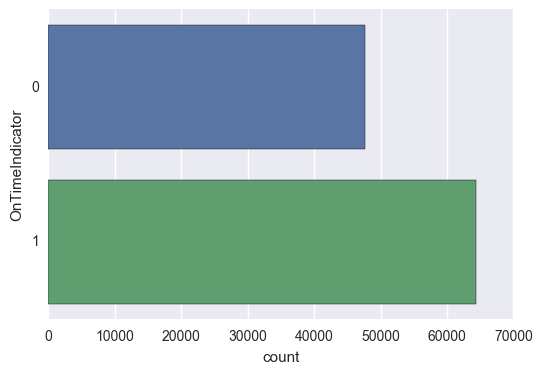

In [30]:
#show classes, we need to ensure there isn't a major class imbalance
ax = sns.countplot(y =  OnTime['OnTimeIndicator'])

There's a bit of class imbalance but probably not enough to worry about

In [65]:
#One Hot Encode any categorical variables
#Definitely origin and destination variables
#Aircraft Code

cols_to_encode = ['origin', 'destination', 'aircraft_type_cde', 'day_of_week', 'TimeBucket']
OnTime = pd.get_dummies(OnTime,columns = cols_to_encode)

In [67]:
OnTime.dtypes
OnTime.shape

(112059, 257)

In [ ]:
#Define our X and Y Sets

#Y set: 
Y=OnTime['OnTimeIndicator']

#X Set:



In [ ]:
#Naive Bayes

In [ ]:
#KNN

%%time

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline(
    [('PCA_Eric',PCA(n_components=300,svd_solver='randomized')),
     ('CLF_Eric',KNeighborsClassifier(n_neighbors=1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN, pipeline accuracy', total_accuracy)

In [ ]:
#Random Forest